In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn import linear_model as lm
from scipy.optimize import nnls, lsq_linear

In [2]:
# reproducible results
np.random.seed(0)

n, p = 20, 10
X = np.random.normal(size=(n, p))
y = np.random.normal(size=n)

# alphas to be used the paths
n_alphas = 200
alphas = np.logspace(-7, 0, n_alphas)

In [3]:
def rsquare(y, yhat):
    residuals = np.linalg.norm(y - yhat, axis=1)
    r2 = 1 - residuals**2 / np.linalg.norm(y - y.mean())**2
    return r2

In [4]:
def plot_path(alphas, coefs, rsquare, title, axes=None):
    #fig, ax = plt.subplots(nrows=2, sharex=True) if axes is None else (None, axes)
    axc, axr = axes
    axc.plot(alphas, coefs)
    axc.set_xscale('log')
    axc.set_ylabel('weights')
    axc.set_title(title)
    axr.plot(alphas, rsquare)
    axr.set_ylabel('$R^2$')
    axr.set_xlabel(r'$\alpha$')
    axr.set_title('$R^2$')

In [5]:
def ridge_path(X, y, alphas):
    coefs = []
    scores = []
    for a in alphas:
        ridge = lm.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_)
        scores.append(ridge.score(X, y))
    coefs = np.vstack(coefs).T
    r2 = np.hstack(scores)
    return alphas, coefs, r2


def ols_ridge(X, y, alpha, bounds=None):
    """return Ridge coefficients by simple OLS"""
    p = X.shape[1]
    if bounds is None:
        bounds = (-np.inf, np.inf)
        Xmod = X.T @ X + alpha * np.eye(p)
        ymod = X.T @ y
    else:
        Xmod = np.vstack((X, alpha * np.eye(p)))
        ymod = np.hstack((y, np.zeros(p)))
    res = lsq_linear(Xmod, ymod, bounds=bounds)
    return res.x


def ols_ridge_path(X, y, alpha, bounds=None):
    """return Ridge full path by simple OLS"""
    coefs = []
    for a in alphas:
        c = ols_ridge(X, y, alpha=a, bounds=bounds)
        coefs.append(c)
    coefs = np.vstack(coefs).T
    yhat = (X @ coefs).T
    r2 = rsquare(y, yhat)
    return alphas, coefs, r2


def ridge_path_via_elasticnet(X, y, alphas):
    eln = lm.ElasticNet(l1_ratio=0, fit_intercept=False)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # in this case ElasticNet fails to converge for large alphas
        act_alphas, coefs, dual_gaps = eln.path(X, y, alphas=alphas)

    yhat = (X @ coefs).T
    r2 = rsquare(y, yhat)
    return act_alphas, coefs, r2


def nn_ridge_path_via_elasticnet(X, y, alphas):
    eln = lm.ElasticNet(l1_ratio=0, fit_intercept=False)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # in this case ElasticNet fails to converge for large alphas
        act_alphas, coefs, dual_gaps = eln.path(X, y, alphas=alphas, positive=True)

    yhat = (X @ coefs).T
    r2 = rsquare(y, yhat)
    return act_alphas, coefs, r2


def nnls_ridge(X, y, alpha):
    """return non-negative Ridge coefficients"""
    p = X.shape[1]
    Xext = np.vstack((X, alpha * np.eye(p)))
    yext = np.hstack((y, np.zeros(p)))
    coefs, _ = nnls(Xext, yext)
    return coefs


def nnls_ridge_path(X, y, alpha):
    """return non-negative Ridge full path by NNLS"""
    coefs = []
    for a in alphas:
        c = nnls_ridge(X, y, alpha=a)
        coefs.append(c)
    coefs = np.vstack(coefs).T
    yhat = (X @ coefs).T
    r2 = rsquare(y, yhat)
    return alphas, coefs, r2

In [6]:
ops = [
    ('Ridge', ridge_path),
    ('Ridge by OLS', ols_ridge_path),
    ('Ridge by ElNet', ridge_path_via_elasticnet),
    (None, None),
    ('Ridge by NNLS', nnls_ridge_path),
    ('Ridge by ElNet:positive', nn_ridge_path_via_elasticnet),
]

In [7]:
dct = {}
for title, fun in ops:
    if title is None:
        continue
    dct[title] = fun(X, y, alphas)

vmin = np.array([(coefs.min(), r2.min()) for act_alphas, coefs, r2 in dct.values()])
vmax = np.array([(coefs.max(), r2.max()) for act_alphas, coefs, r2 in dct.values()])

margin = 0.05 * (vmax - vmin)
vmin, vmax = vmin - margin, vmax + margin

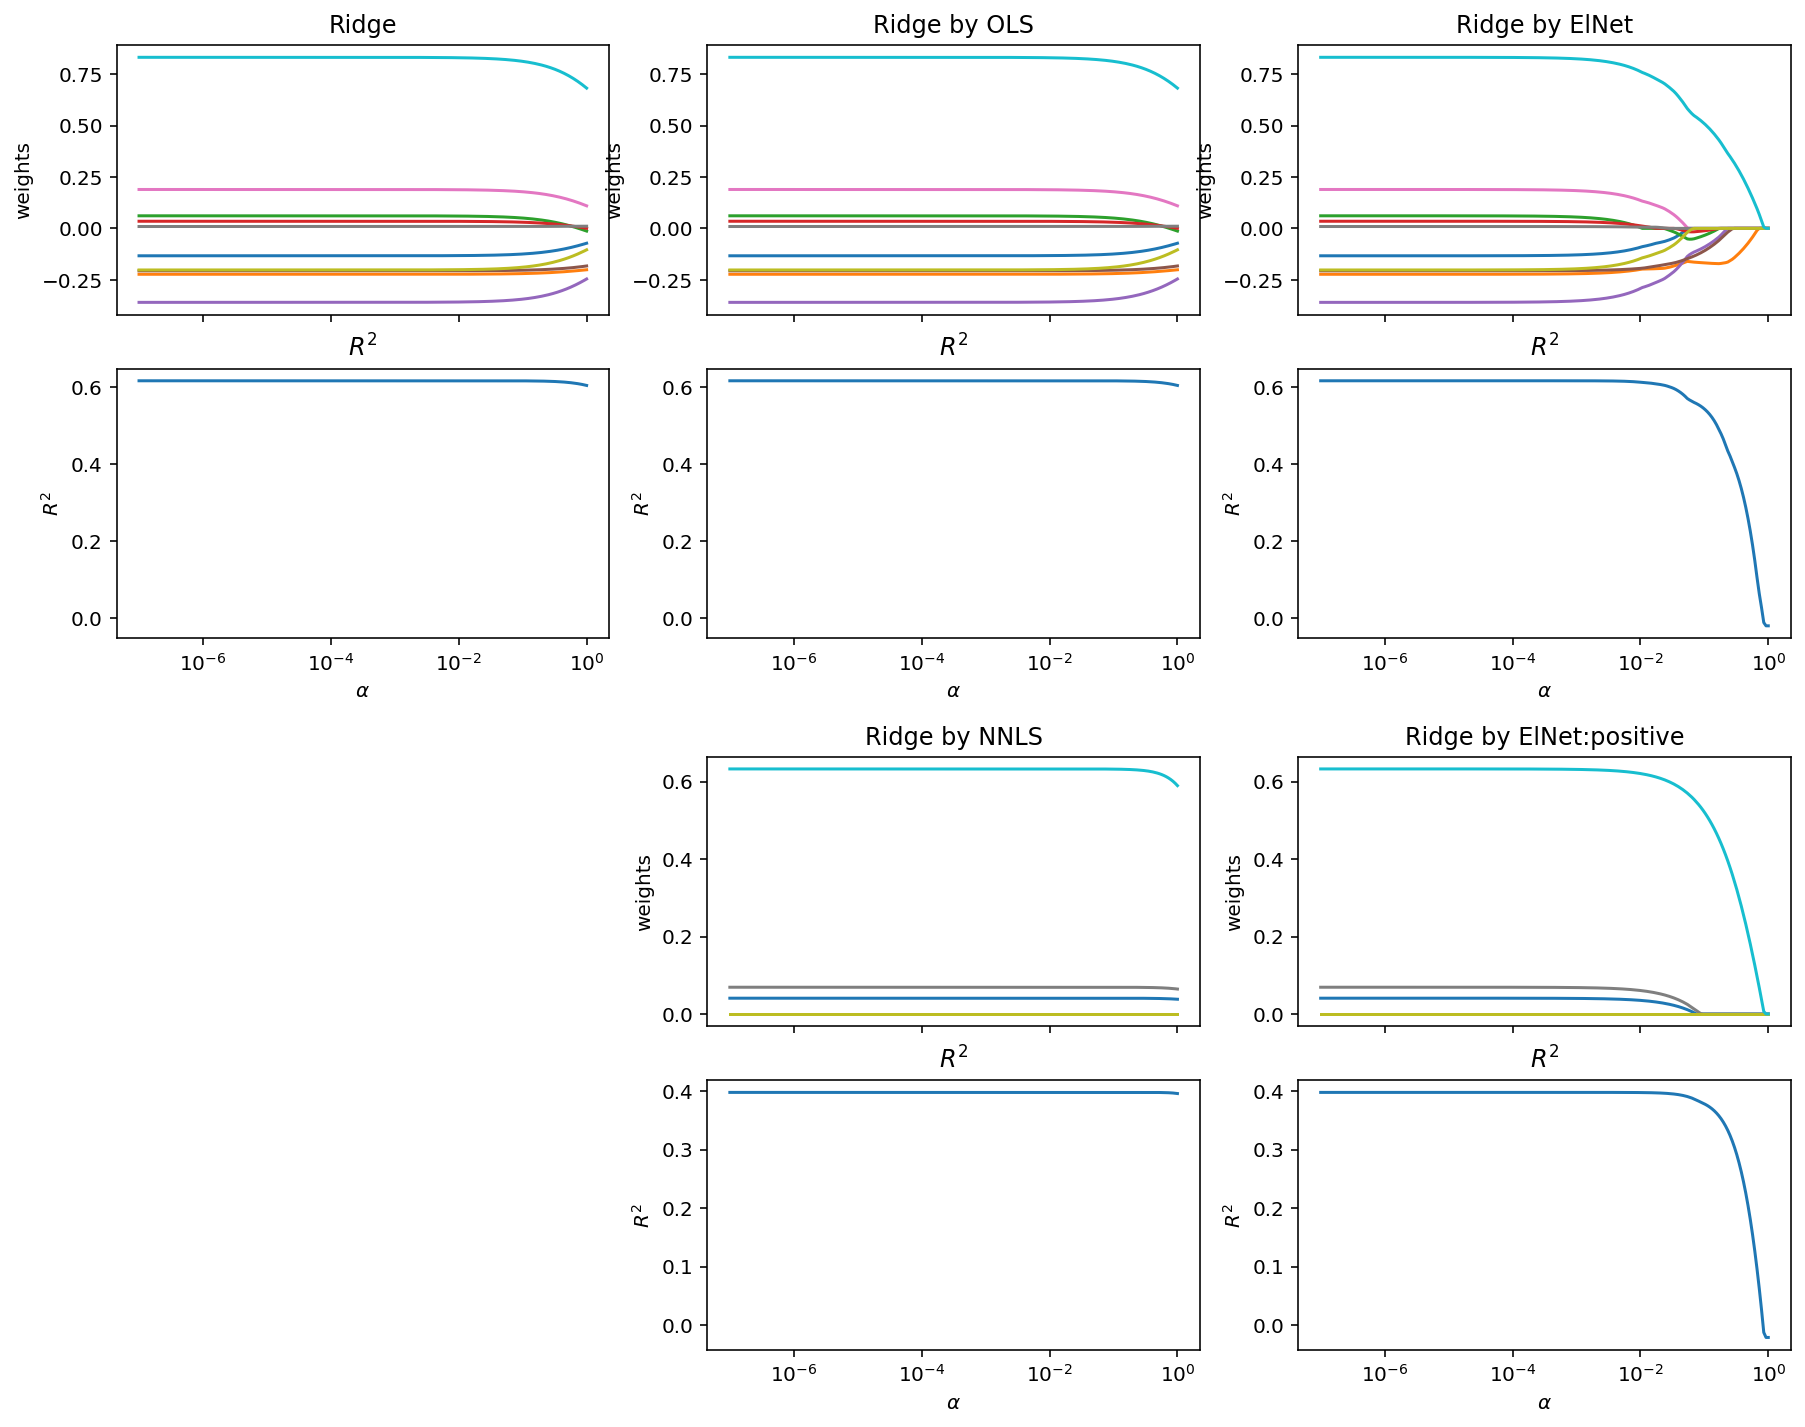

In [8]:
fig = plt.figure(figsize=(15, 12), constrained_layout=False)
outer_grid = fig.add_gridspec(ncols=3, nrows=2)

for i, (facet, (title, fun)) in enumerate(zip(list(outer_grid), ops)):
    slc = slice(0, 3) if i < 3 else slice(3, None)
    cmin, r2min = vmin[slc].min(0)
    cmax, r2max = vmax[slc].max(0)
    if title is None:
        continue
    axes = facet.subgridspec(nrows=2, ncols=1).subplots(sharex=True)
    act_alphas, coefs, r2 = dct[title]
    plot_path(act_alphas, coefs.T, r2, title, axes)
    axes[0].set_ylim(cmin, cmax)
    axes[1].set_ylim(r2min, r2max)